You need to register at https://www.bingmapsportal.com/ to get a key. After that, create a file named `api_keys.py`:
```
KEYS = {}
KEYS['BING_KEY'] = "my_super_duper_cool_key"
```

In [1]:
from api_keys import KEYS # the file api_keys.py is in .gitignore
from map_utils import *

BING_KEY = KEYS['BING_KEY']

In [2]:
# https://learn.microsoft.com/en-us/bingmaps/rest-services/imagery/get-a-static-map
BING_API_URL = "https://dev.virtualearth.net/REST/v1/Imagery/Metadata/{imagerySet}/{centerPoint}?zl={zoomLevel}&key={BING_KEY}"

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import requests

from io import BytesIO
from PIL import Image

import osmnx as ox # https://github.com/gboeing/osmnx
import geopandas as gpd # https://geopandas.org/
import mercantile as mc # https://github.com/mapbox/mercantile

## Getting some tiles
https://learn.microsoft.com/en-us/bingmaps/rest-services/imagery/get-imagery-metadata#template-parameters

In [4]:
polymtl = {'lat': 45.504929226344395, "lon": -73.6131723730051}

In [5]:
imagerySet = "Aerial"
centerPoint = f"{polymtl['lat']},{polymtl['lon']}"
orientation = 0
altitudeMeters = 500

zoomLevel = altitude2zoomlevel(altitudeMeters)
response = requests.get(BING_API_URL.format(imagerySet=imagerySet, 
                                            centerPoint=centerPoint,
                                            zoomLevel=zoomLevel,
                                            BING_KEY=BING_KEY)).json()
assert response['authenticationResultCode'] == 'ValidCredentials'
resources = response['resourceSets'][0]['resources'][0]
imageHeight = resources['imageHeight']
imageWidth = resources['imageWidth']
imageUrl = resources['imageUrl']
imageUrlSubdomains = resources['imageUrlSubdomains']

imgstr = requests.get(response['brandLogoUri'], allow_redirects=True).content
bing_logo = Image.open(BytesIO(imgstr))

print(response['copyright'])
bing_logo

Copyright © 2023 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.


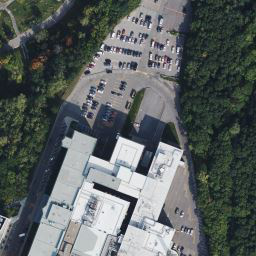

In [6]:
imgstr = requests.get(imageUrl, allow_redirects=True).content
tile = Image.open(BytesIO(imgstr))
tile

## Get information from Open Street Maps

From https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=tags#osmnx.geometries.geometries_from_point:   
```
tags (dict) – Dict of tags used for finding objects in the selected area... The dict keys should be OSM tags, (e.g., building, landuse, highway, etc) and the dict values should be either True to retrieve all items with the given tag, or a string to get a single tag-value combination, or a list of strings to get multiple values for the given tag. For example, tags = {‘building’: True} would return all building footprints in the area. tags = {‘amenity’:True, ‘landuse’:[‘retail’,’commercial’], ‘highway’:’bus_stop’} would return all amenities, landuse=retail, landuse=commercial, and highway=bus_stop.
```

* https://wiki.openstreetmap.org/wiki/Tags
* https://wiki.openstreetmap.org/wiki/Map_features

In [7]:
ox.settings.useful_tags_way

['bridge',
 'tunnel',
 'oneway',
 'lanes',
 'ref',
 'name',
 'highway',
 'maxspeed',
 'service',
 'access',
 'area',
 'landuse',
 'width',
 'est_width',
 'junction']

In [8]:
# tags = {'natural': True}
tags = {'building': True}
latitudeDegrees = polymtl['lat']
dist = h_dist(latitudeDegrees, altitudeMeters)
buildings = ox.geometries_from_point((polymtl['lat'], polymtl['lon']), tags, dist=dist)

minx, miny, maxx, maxy  = mc.bounds(mc.tile(polymtl['lon'], polymtl['lat'], zoomLevel, truncate=False))
buildings = gpd.clip(buildings, (minx, miny, maxx, maxy))

/home/ricardodeazambuja/miniforge3/envs/pytorch/lib/python3.8/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


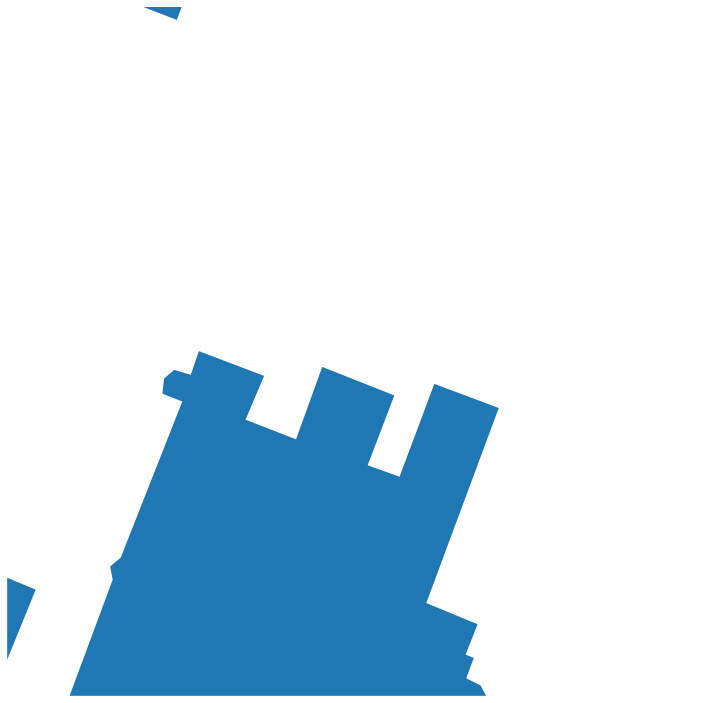

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=0)
buildings.plot(ax=axs)
axs.margins(0)
# axs.margins(x=0,y=0)
axs.set_xlim(minx, maxx)
axs.set_ylim(miny, maxy)
axs.set_axis_off()

## Overlay

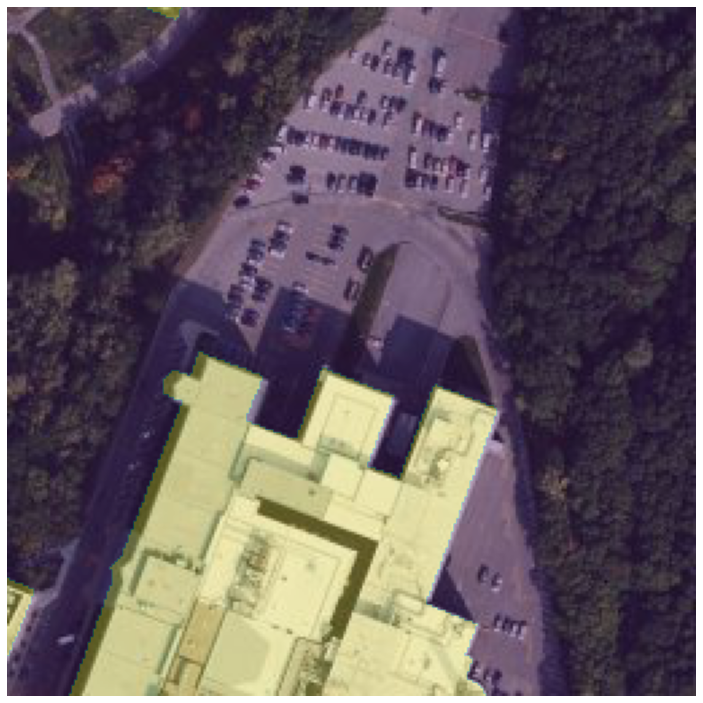

In [10]:
import rasterio.features
import rasterio.transform

img = rasterio.features.rasterize(buildings.geometry.values, out_shape=tile.size, fill=0,
                                  transform=rasterio.transform.from_bounds(minx, miny, maxx, maxy, *tile.size),
                                  dtype='uint8')

fig, axs = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=0)
axs.imshow(tile)
axs.imshow(img, alpha=0.3)
axs.margins(0)
# axs.margins(x=0,y=0)
axs.set_axis_off()

